# Classifiers Comparison

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # ignore Tensorflow infos and warnings

import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

import sklearn.tree
import sklearn.neighbors

import xgboost as xgb

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ignore FutureWarnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Load Dataset

## Download pre-processed datasets

In [2]:
!wget https://zenodo.org/record/8239343/files/latent_space_dataset_12activities.zip
!unzip -o latent_space_dataset_12activities.zip
!rm latent_space_dataset_12activities.zip

--2023-08-11 16:35:34--  https://zenodo.org/record/8239343/files/latent_space_dataset_12activities.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66820932 (64M) [application/octet-stream]
Saving to: ‘latent_space_dataset_12activities.zip’

latent_space_datase 100%[===================>]  63,72M  1,24MB/s    in 50s     

2023-08-11 16:36:25 (1,27 MB/s) - ‘latent_space_dataset_12activities.zip’ saved [66820932/66820932]

Archive:  latent_space_dataset_12activities.zip
  inflating: latent_space_dataset_12activities/s1a_f_ls5.pkl  
  inflating: latent_space_dataset_12activities/s1a_a2_ls5.pkl  
  inflating: latent_space_dataset_12activities/s1a_a2_ls4.pkl  
  inflating: latent_space_dataset_12activities/s1a_f_ls4.pkl  
  inflating: latent_space_dataset_12activities/s1a_a3_ls3.pkl  
  inflating: latent_space_dataset_12activities/s1a_a3_ls2.pkl  
  inflating:

### Load a specific dataset

An `experiment` is a dictionary with the following elements:
* scenario: defines the location of the experiment and the monitor utilized (e.g., `s1a` means scenario S1 and receiver A)
* vae_name: VAE architecture, can be `No-Fused-X` (`X` ranging from `1` to `4`), `Early-Fusing`, or `Delayed-Fusing`
* latent_size: dimensionality of the Gaussians RVs in the latent space, can be 2, 3, 4, or 5
* num_activities: number of activities to consider

In [3]:
def load_dataset(experiment):
    scenario = experiment['scenario']
    name = experiment['vae_name']
    latent_size = experiment['latent_size']
    num_activities = experiment['num_activities']
    num_antennas = 4

    # define the feature columns
    mus = [f'mu{i}' for i in range(latent_size)]
    sigmas = [f'sigma{i}' for i in range(latent_size)]
    fcolumns = mus + sigmas

    if name == 'No-Fused-1':
        filename = f'./latent_space_dataset_12activities/{scenario}_a0_ls{latent_size}.pkl'
    elif name == 'No-Fused-2':
        filename = f'./latent_space_dataset_12activities/{scenario}_a1_ls{latent_size}.pkl'
    elif name == 'No-Fused-3':
        filename = f'./latent_space_dataset_12activities/{scenario}_a2_ls{latent_size}.pkl'
    elif name == 'No-Fused-4':
        filename = f'./latent_space_dataset_12activities/{scenario}_a3_ls{latent_size}.pkl'
    elif name == 'Early-Fusing':
        filename = f'./latent_space_dataset_12activities/{scenario}_f_ls{latent_size}.pkl'

    # 'Delayed-Fusing' architecture requires extra care because more files are loaded at once
    if name == 'Delayed-Fusing':
        filename = f'./latent_space_dataset_12activities/{scenario}_a0_ls{latent_size}.pkl'
        with open(f'{filename}', 'rb') as f:
            data, labels = pickle.load(f)
        for ant in range(1, num_antennas):
            filename = f'./latent_space_dataset_12activities/{scenario}_a{ant}_ls{latent_size}.pkl'
            with open(f'{filename}', 'rb') as f:
                data_tmp, labels_tmp = pickle.load(f)
            data = np.concatenate((data, data_tmp), axis=1)
        # extend feature columns to take into account all 4 antennas
        fcolumns = [f'{fcolumns[i]}_{j}' for j in range(num_antennas) for i in range(latent_size * 2)]
    else:
        with open(f'{filename}', 'rb') as f:
            data, labels = pickle.load(f)

    # labels are categoricals
    labels = np.asarray(labels, dtype=np.int32)

    # load the data into a Pandas dataframe
    df = pd.DataFrame(data, columns=fcolumns)
    df['signal'] = labels

    # apply standard scaler
    scaler = StandardScaler().fit(df[fcolumns])
    df[fcolumns] = scaler.transform(df[fcolumns])

    # split train/test dataset
    X_train, X_test, y_train, y_test = train_test_split(
        df[fcolumns], df['signal'], test_size=0.2, random_state=42, stratify=df['signal']
    )

    # Select only desired activities
    all_classes = ["Walk", "Run", "Jump", "Sit", "Empty", "Stand", "Waving", "Clap", "Lay down", "Wipe", "Squat", "Stretch"]
    semantic_classes = all_classes[:num_activities]

    return {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'semantic_classes': semantic_classes,
        'scaler': scaler
    }

Define a list of experiments to run:

In [4]:
experiment_list = [
    {'scenario': 's1a', 'vae_name': 'No-Fused-1', 'latent_size': 5, 'num_activities': 12},
    {'scenario': 's1a', 'vae_name': 'No-Fused-2', 'latent_size': 5, 'num_activities': 12},
    {'scenario': 's1a', 'vae_name': 'No-Fused-3', 'latent_size': 5, 'num_activities': 12},
    {'scenario': 's1a', 'vae_name': 'No-Fused-4', 'latent_size': 5, 'num_activities': 12},
    {'scenario': 's1a', 'vae_name': 'Early-Fusing', 'latent_size': 5, 'num_activities': 12},
    {'scenario': 's1a', 'vae_name': 'Delayed-Fusing', 'latent_size': 5, 'num_activities': 12},
]

# Test Models

The boolean `train_from_scratch` defines whether to use pre-trained models or train new models from scratch.

In [5]:
train_from_scratch = False

!wget https://zenodo.org/record/8239343/files/models_12activities.zip
!unzip -o models_12activities.zip
!rm models_12activities.zip

--2023-08-11 16:36:27--  https://zenodo.org/record/8239343/files/models_12activities.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130964381 (125M) [application/octet-stream]
Saving to: ‘models_12activities.zip’

models_12activities 100%[===================>] 124,90M   880KB/s    in 3m 57s  

2023-08-11 16:40:24 (541 KB/s) - ‘models_12activities.zip’ saved [130964381/130964381]

Archive:  models_12activities.zip
   creating: models_12activities/
   creating: models_12activities/knn/
  inflating: models_12activities/knn/s1a_No-Fused-4_ls2_12activities.pkl  
  inflating: models_12activities/knn/s1a_No-Fused-3_ls4_12activities.pkl  
  inflating: models_12activities/knn/s1a_No-Fused-1_ls2_12activities.pkl  
  inflating: models_12activities/knn/s1a_No-Fused-2_ls5_12activities.pkl  
  inflating: models_12activities/knn/s1a_Delayed-Fusing_ls2_12activities.pk

## Decision Tree

In [6]:
# Parameters TO TUNE
loss = "log_loss"
max_leaves = 14

output_directory = 'outputs/dt'
models_directory = 'models_12activities/dt'
!mkdir -p {output_directory}/cm

/opt/miniconda3/envs/tmc-csi/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tmc-csi/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tmc-csi/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2310
           1       0.51      1.00      0.68      2310
           2       0.78      0.67      0.72      2310
           3       0.91      0.89      0.90      2310
           4       0.62      0.74      0.67      2310
           5       0.74      0.80      0.77      2310
           6       0.64      0.57      0.60      2310
           7       0.72      0.75      0.74      2310
           8       0.58      0.45      0.51      2310
           9       0.59      0.73      0.65      2310
          10       0.56      0.80      0.66      2310
          11       1.00      0.59      0.74      2310

    accuracy                           0.67     27720
   macro avg       0.64      0.67      0.64     27720
weighted avg       0.64      0.67      0.64     27720

              precision    recall  f1-score   support

           0       0.96      0.40      0.57      2310
           1       0.61 

/opt/miniconda3/envs/tmc-csi/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tmc-csi/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tmc-csi/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2310
           1       0.44      0.90      0.59      2310
           2       0.75      0.60      0.67      2310
           3       0.87      0.89      0.88      2310
           4       0.84      0.84      0.84      2310
           5       0.77      0.76      0.77      2310
           6       0.53      0.61      0.56      2310
           7       0.71      0.75      0.73      2310
           8       0.94      0.59      0.72      2310
           9       0.56      0.92      0.70      2310
          10       0.62      0.59      0.61      2310
          11       0.88      0.65      0.75      2310

    accuracy                           0.68     27720
   macro avg       0.66      0.68      0.65     27720
weighted avg       0.66      0.68      0.65     27720



/opt/miniconda3/envs/tmc-csi/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tmc-csi/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tmc-csi/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2310
           1       0.50      0.98      0.66      2310
           2       0.83      0.95      0.89      2310
           3       0.90      0.89      0.89      2310
           4       0.91      0.66      0.76      2310
           5       0.79      0.82      0.80      2310
           6       0.72      0.61      0.66      2310
           7       0.73      0.76      0.74      2310
           8       0.44      0.71      0.54      2310
           9       0.96      0.47      0.63      2310
          10       0.61      0.94      0.74      2310
          11       0.98      0.60      0.75      2310

    accuracy                           0.70     27720
   macro avg       0.70      0.70      0.67     27720
weighted avg       0.70      0.70      0.67     27720

              precision    recall  f1-score   support

           0       0.85      0.44      0.58      2310
           1       0.58 

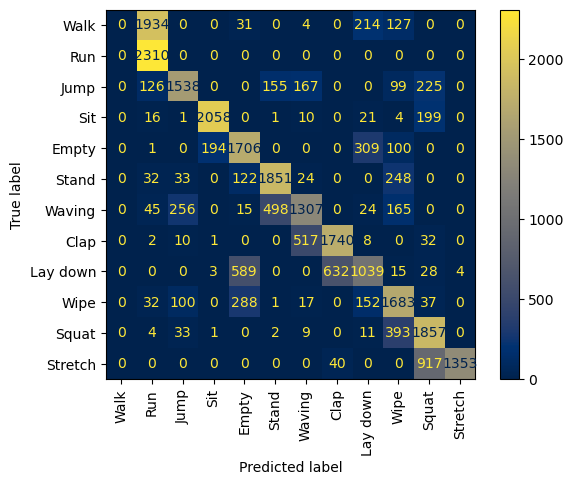

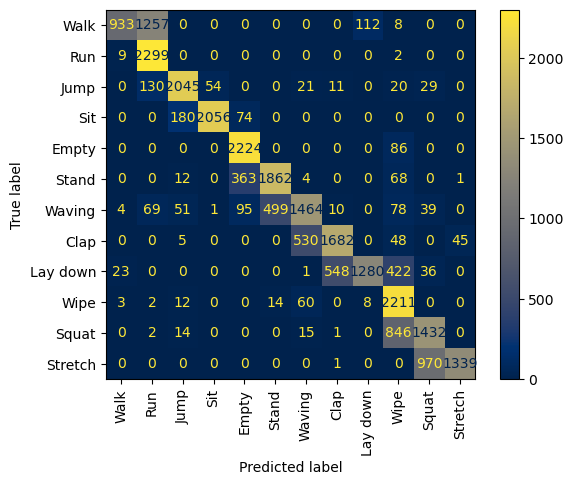

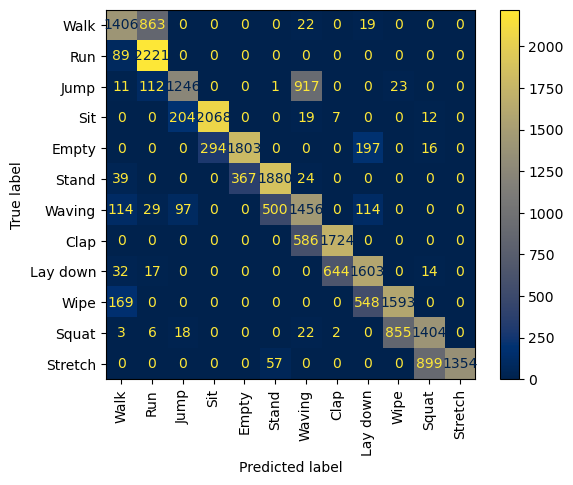

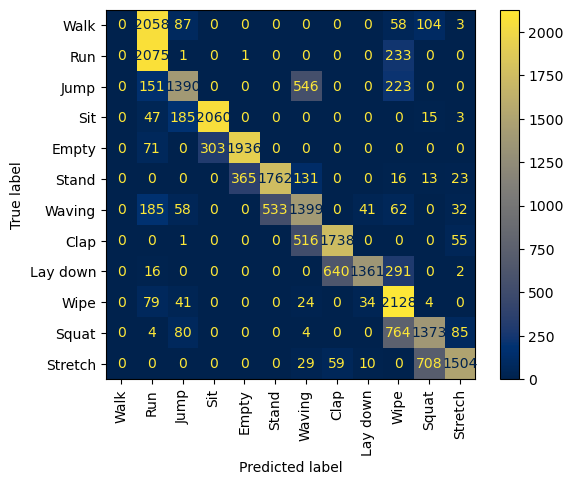

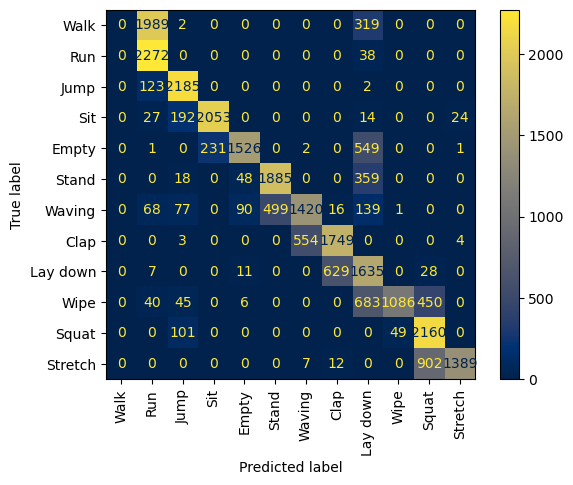

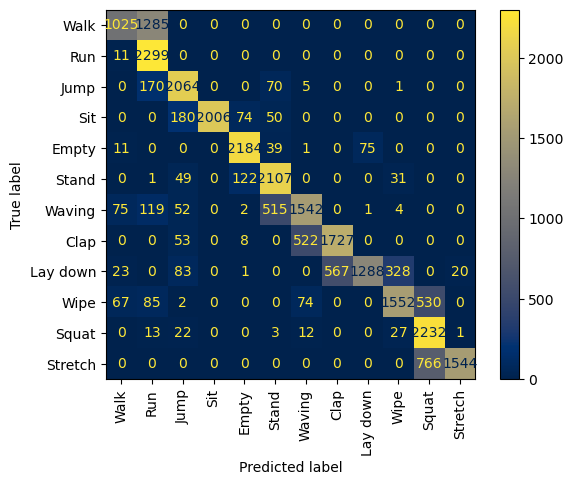

In [7]:
for exp in experiment_list:
    full_name = f"{exp['scenario']}_{exp['vae_name']}_ls{exp['latent_size']}_{exp['num_activities']}activities"
    
    dataset = load_dataset(exp)

    X_train = dataset['X_train']
    y_train = dataset['y_train']
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    semantic_classes = dataset['semantic_classes']
    scaler = dataset['scaler']

    clf = sklearn.tree.DecisionTreeClassifier(criterion=loss, max_leaf_nodes=max_leaves)
    
    if train_from_scratch:
        # Train and test the model
        clf.fit(scaler.inverse_transform(X_train), y_train)
        # Save the model
        !mkdir -p ./models/dt
        with open(f'./{models_directory}/{full_name}.pkl', 'wb') as f:
            pickle.dump(clf, f)
    else:
        # Load the model
        with open(f'./{models_directory}/{full_name}.pkl', 'rb') as f:
            clf = pickle.load(f)
    
    predicted = clf.predict(scaler.inverse_transform(X_test))
        
    report = classification_report(y_test, predicted)
    cm = confusion_matrix(y_test, predicted)

    # Save the classification report
    print(report)
    with open(f'./{output_directory}/report_{full_name}.txt','w') as f:
        f.write(report)

    # Save the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset["semantic_classes"])
    plot = disp.plot(cmap='cividis', xticks_rotation='vertical')

    plot.figure_.savefig(f'./{output_directory}/cm/{full_name}.pdf', bbox_inches='tight') 

## kNN

In [8]:
# Parameter TO TUNE
kmax = 300

output_directory = 'outputs/knn'
models_directory = 'models_12activities/knn'
!mkdir -p {output_directory}/cm

              precision    recall  f1-score   support

           0       0.64      0.45      0.53      2310
           1       0.61      0.86      0.71      2310
           2       0.79      0.69      0.74      2310
           3       0.95      0.95      0.95      2310
           4       0.63      0.83      0.72      2310
           5       0.73      0.84      0.78      2310
           6       0.60      0.66      0.63      2310
           7       0.80      0.74      0.77      2310
           8       0.75      0.54      0.63      2310
           9       0.76      0.59      0.66      2310
          10       0.65      0.78      0.71      2310
          11       0.87      0.72      0.79      2310

    accuracy                           0.72     27720
   macro avg       0.73      0.72      0.72     27720
weighted avg       0.73      0.72      0.72     27720

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2310
           1       0.94 

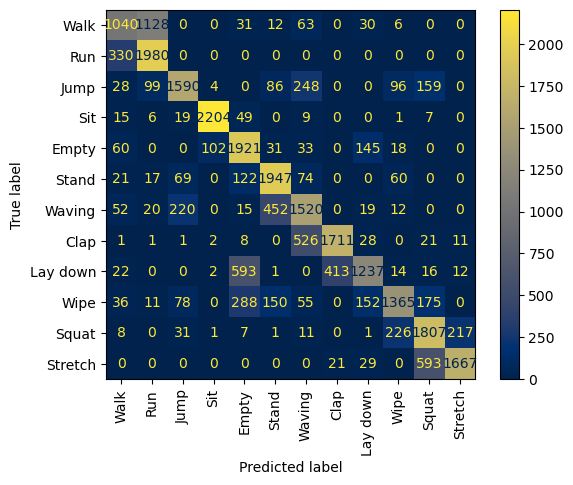

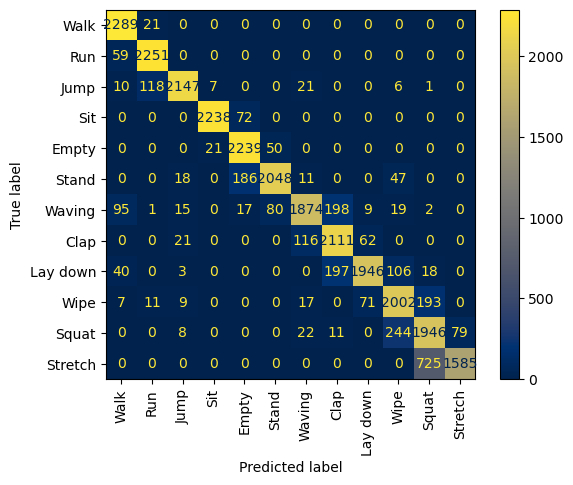

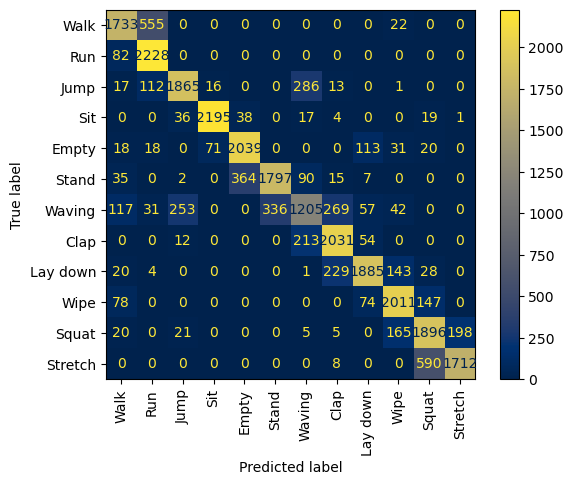

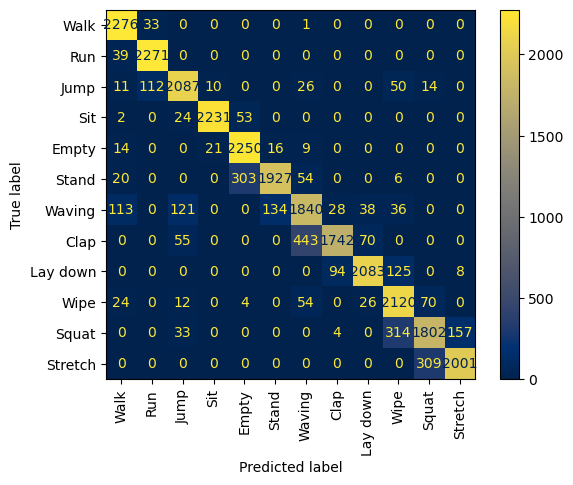

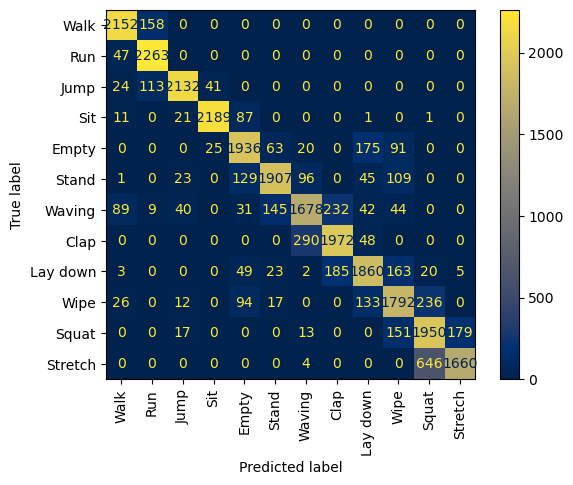

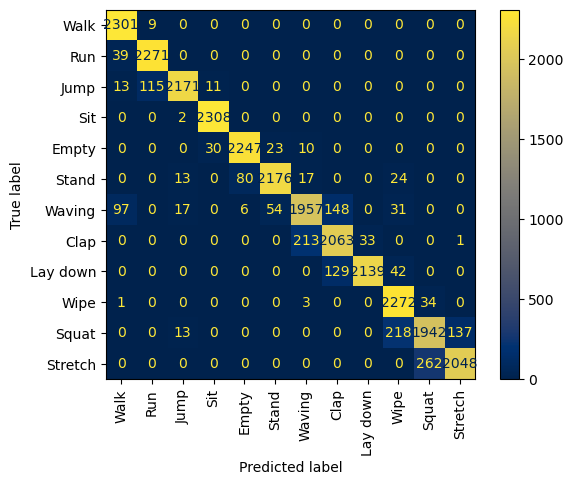

In [9]:
for exp in experiment_list:
    full_name = f"{exp['scenario']}_{exp['vae_name']}_ls{exp['latent_size']}_{exp['num_activities']}activities"
    
    dataset = load_dataset(exp)

    X_train = dataset['X_train']
    y_train = dataset['y_train']
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    semantic_classes = dataset['semantic_classes']
    scaler = dataset['scaler']

    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=kmax)
    
    if train_from_scratch:
        # Train and test the model
        clf.fit(scaler.inverse_transform(X_train), y_train)
        # Save the model
        !mkdir -p ./models/knn
        with open(f'./{models_directory}/{full_name}.pkl', 'wb') as f:
            pickle.dump(clf, f)
    else:
        # Load the model
        with open(f'./{models_directory}/{full_name}.pkl', 'rb') as f:
            clf = pickle.load(f)
            
    predicted = clf.predict(scaler.inverse_transform(X_test))

    report = classification_report(y_test, predicted)
    cm = confusion_matrix(y_test, predicted)
            
    # Save the classification report
    print(report)
    with open(f'./{output_directory}/report_{full_name}.txt','w') as f:
        f.write(report)

    # Save the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset["semantic_classes"])
    plot = disp.plot(cmap='cividis', xticks_rotation='vertical')

    plot.figure_.savefig(f'./{output_directory}/cm/{full_name}.pdf', bbox_inches='tight')

## XGboost

In [10]:
# Parameters TO TUNE
maxdepth = 5
n_estimators = 3

output_directory = 'outputs/xgboost'
models_directory = 'models_12activities/xgboost'
!mkdir -p {output_directory}/cm

              precision    recall  f1-score   support

           0       0.62      0.49      0.55      2310
           1       0.61      0.80      0.70      2310
           2       0.78      0.70      0.74      2310
           3       0.95      0.95      0.95      2310
           4       0.63      0.83      0.72      2310
           5       0.72      0.86      0.78      2310
           6       0.60      0.66      0.63      2310
           7       0.79      0.74      0.77      2310
           8       0.76      0.53      0.63      2310
           9       0.79      0.57      0.66      2310
          10       0.65      0.80      0.71      2310
          11       0.90      0.71      0.79      2310

    accuracy                           0.72     27720
   macro avg       0.73      0.72      0.72     27720
weighted avg       0.73      0.72      0.72     27720

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2310
           1       0.92 

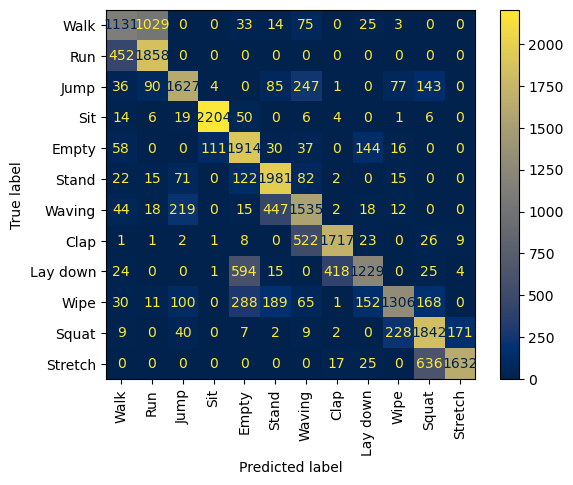

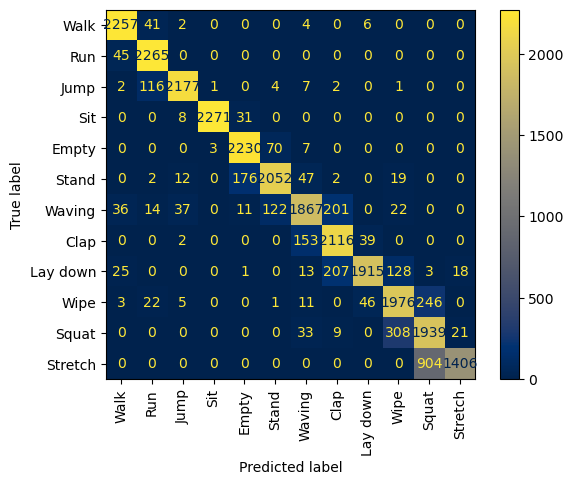

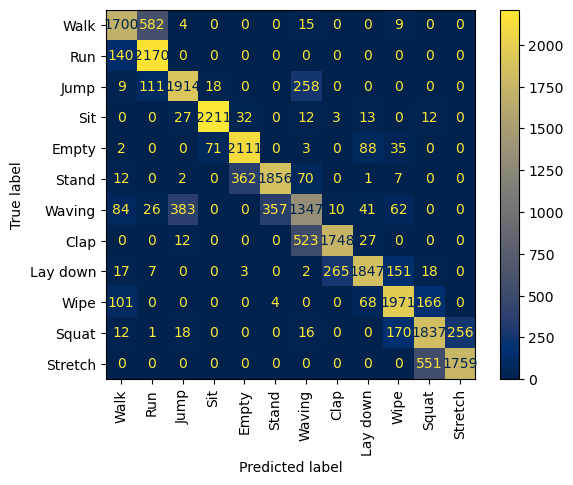

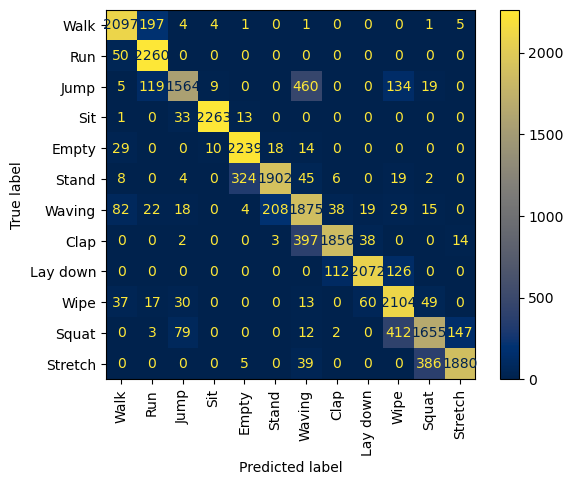

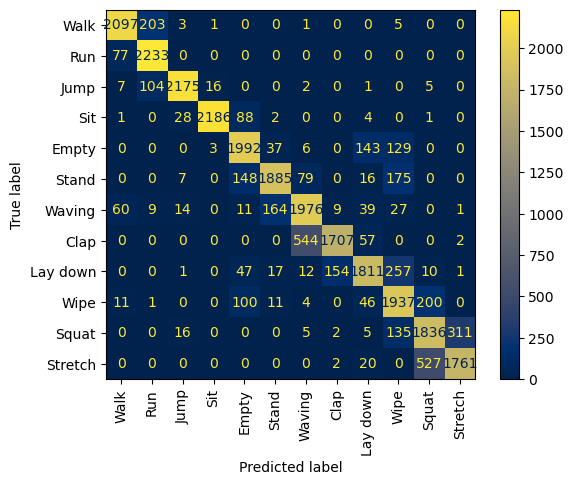

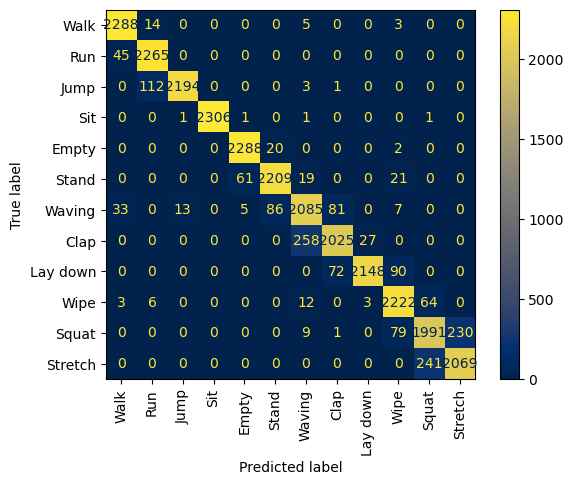

In [11]:
for exp in experiment_list:
    full_name = f"{exp['scenario']}_{exp['vae_name']}_ls{exp['latent_size']}_{exp['num_activities']}activities"
    
    dataset = load_dataset(exp)

    X_train = dataset['X_train']
    y_train = dataset['y_train']
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    semantic_classes = dataset['semantic_classes']
    scaler = dataset['scaler']

    clf = xgb.XGBClassifier(max_depth=maxdepth, n_estimators=n_estimators, eval_metric=confusion_matrix)

    if train_from_scratch:
            # Train and test the model
            clf.fit(X_train, y_train)
            # Save the model
            !mkdir -p ./models/xgboost
            with open(f'./{models_directory}/{full_name}.pkl', 'wb') as f:
                pickle.dump(clf, f)
    else:
        # Load the model
        with open(f'./{models_directory}/{full_name}.pkl', 'rb') as f:
            clf = pickle.load(f)
            
    predicted = clf.predict(X_test)

    report = classification_report(y_test, predicted)
    cm = confusion_matrix(y_test, predicted)

    # Save the classification report
    print(report)
    with open(f'./{output_directory}/report_{full_name}.txt','w') as f:
        f.write(report)

    # Save the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset["semantic_classes"])
    plot = disp.plot(cmap='cividis', xticks_rotation='vertical')

    plot.figure_.savefig(f'./{output_directory}/cm/{full_name}.pdf', bbox_inches='tight')

## MLP

In [12]:
batch_size = 50
epochs = 20

output_directory = 'outputs/mlp'
models_directory = 'models_12activities/mlp'
!mkdir -p {output_directory}/cm

In [13]:
def create_new_mlp_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(X_train.shape[1], activation='relu',input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(12, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=[
                    tf.keras.metrics.SparseCategoricalAccuracy()
                    ])
    model.summary()

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 8)                 88        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 12)                108       
                                                                 
Total params: 378
Trainable params: 378
Non-trainable params: 0
_________________________________________________________________
s1a_No-Fused-1_ls5_12activities
              precision    recall  f1-score   support

           0       0.64      0.38      0.48      2310
           1       0.59      0.91      0.72      

Trainable params: 378
Non-trainable params: 0
_________________________________________________________________
s1a_Early-Fusing_ls5_12activities
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2310
           1       0.85      0.95      0.90      2310
           2       0.97      0.91      0.94      2310
           3       0.90      0.98      0.94      2310
           4       0.78      0.82      0.80      2310
           5       0.79      0.82      0.80      2310
           6       0.78      0.57      0.66      2310
           7       0.81      0.83      0.82      2310
           8       0.77      0.81      0.79      2310
           9       0.75      0.71      0.73      2310
          10       0.67      0.88      0.76      2310
          11       0.94      0.66      0.77      2310

    accuracy                           0.82     27720
   macro avg       0.82      0.82      0.82     27720
weighted avg       0.82      0.82      0.8

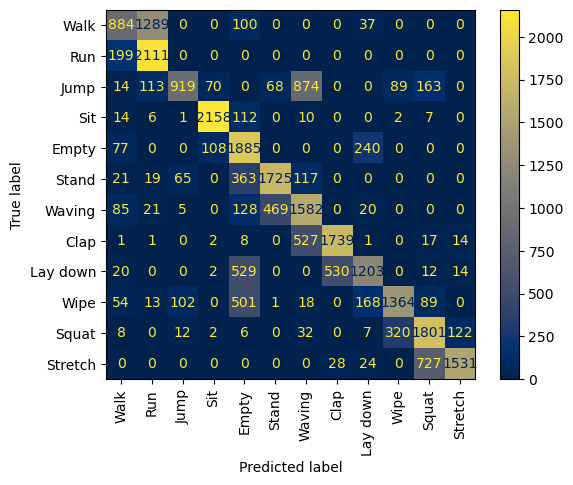

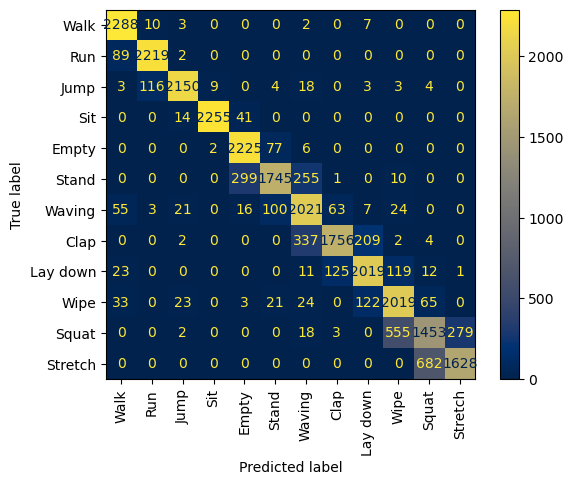

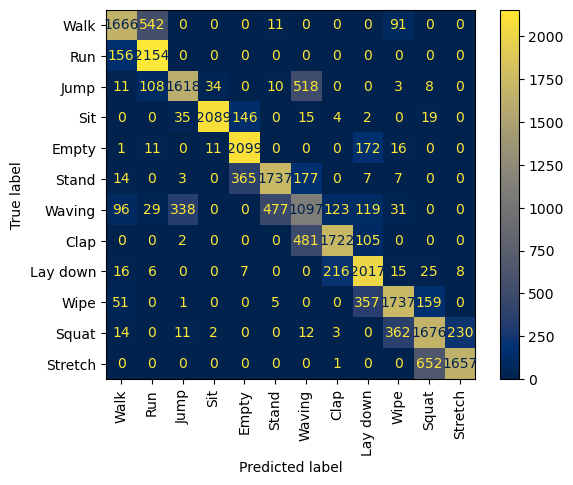

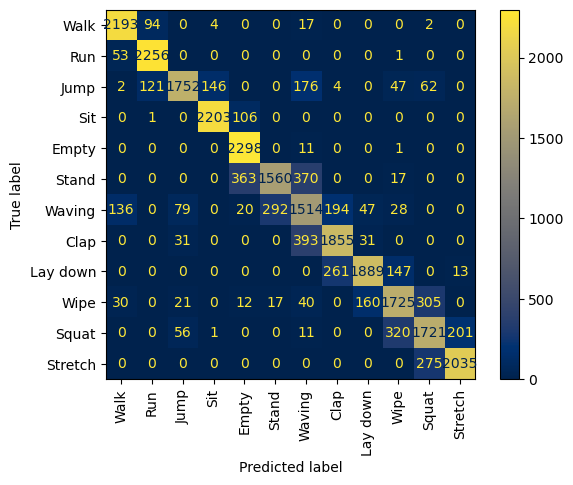

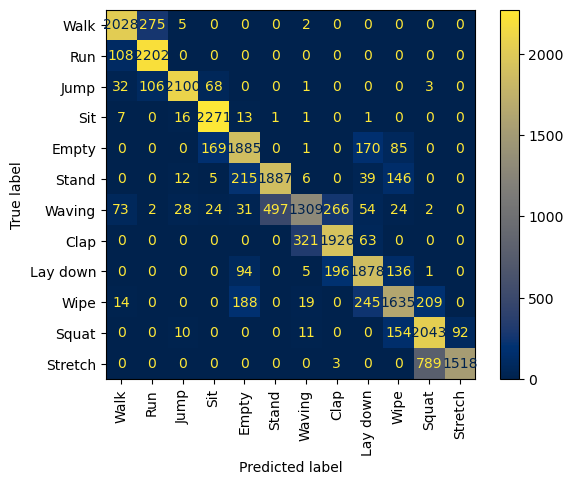

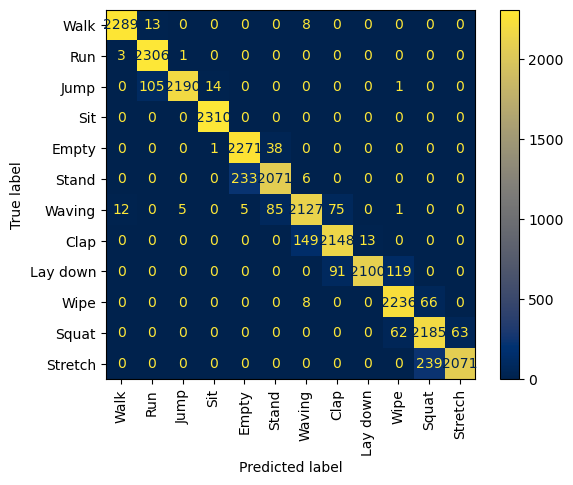

In [14]:
for exp in experiment_list:
    full_name = f"{exp['scenario']}_{exp['vae_name']}_ls{exp['latent_size']}_{exp['num_activities']}activities"
    
    dataset = load_dataset(exp)

    X_train = dataset['X_train']
    y_train = dataset['y_train']
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    semantic_classes = dataset['semantic_classes']
    scaler = dataset['scaler']

    clf = create_new_mlp_model()

    if train_from_scratch:
        clf.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)
        !mkdir -p ./models/mlp
        clf.save_weights(f'./{models_directory}/{full_name}')
    else:
        clf.load_weights(f'./{models_directory}/{full_name}').expect_partial()
    
    predicted = clf.predict(X_test, verbose=0)

    # squeeze output vectors 
    predicted = np.argmax(predicted, axis=1)

    print(f'{full_name}')
    report = classification_report(y_test, predicted)
    cm = confusion_matrix(y_test, predicted)

    # Save the classification report
    print(report)
    with open(f'./{output_directory}/report_{full_name}.txt','w') as f:
        f.write(report)

    # Save the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset["semantic_classes"])
    plot = disp.plot(cmap='cividis', xticks_rotation='vertical')

    plot.figure_.savefig(f'./{output_directory}/cm/{full_name}.pdf', bbox_inches='tight')